In [ ]:
# | echo: false
# | output: false
from fastcore.test import *
from IPython import get_ipython
from IPython.display import display, Markdown, YouTubeVideo
from manim import *
import math
import numpy as np
from scipy.signal import convolve2d
from sympy import (
    Add,
    Derivative,
    Expr,
    Function,
    Indexed,
    IndexedBase,
    latex,
    Mul,
    Symbol,
    symbols,
)
from typing import Dict, Iterable, List, Optional, Sequence, Tuple, Type

## Motivation
The deep learning classes I've taken have all followed a similar progression:

1. First, you learn to do the math by hand, using symbols (the input vector is $x$, the weight matrix is $W$, $z = Wx + b$, etc)
2. Next, you write code to implement the math numerically (manipulating arrays or tensors of numbers). At this stage, you write it from scratch using just NumPy arrays.
3. Finally, you graduate to writing code that uses deep learning frameworks like TensorFlow and PyTorch. 

Step 1 teaches you the theory, and step 3 teaches you the tools that real practitioners use. Step 2 in between teaches you what those tools are doing so you don't approach them as black boxes. I'm a fan. 

I recently took a class on Convolutional Neural Networks. While it followed this progression, it didn't teach the math for back propagation through convolutional layers. I tried to work this out for myself and found that the math wasn't hard, but it was tedious (long expressions, lots of superscripts and subscripts to keep track of). In trying to explore ways to automate some of the tedious parts, I think I found an approach that re-organizes things so that step 2 (writing the code from scratch) borrows an idea from step 3 (automatic differentiation) and as a result, actually helps with step 1 (understanding the math).

### Automatic Differentiation as a Convenience
In the usual progression, the big change between steps 2 and 3 is that the deep learning frameworks give you automatic differentiation capabilities ([`GradientTape`](https://www.tensorflow.org/guide/autodiff) in TensorFlow, [`autograd`](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) in PyTorch). When you write a neural network from scratch, you write the forward and backward passes as separate algorithms that share some data. With auto differentiation, you to write just the forward pass logic and you get the backward pass for free. The framework keeps track of the operations performed in the forward pass and can calculate the partial derivatives required for back propagation automatically. 

Auto differentiation reduces the amount of code you need to write to implement a neural network but it isn't a learning tool. It does its job numerically: given the numerical value of the gradient at some node in a computation graph, you can get the numerical value of the gradient at earlier nodes, but you can't see the derivatives expressed symbolically. You get the answer but the framework doesn't show its work. Classes introduce auto differentiation frameworks late in the curriculum because they're a convenience you earn the right to use after you've worked through the math the hard way. 

### Automatic Differentiation as a Learning Tool
My approach is a hybrid: implementing algorithms from scratch but using a symbolic framework that can auto differentiate while showing its work. It really helped me with my task of deriving the backprop equations for convolutions. This technique isn't a replacement for doing math by hand and I wouldn't blindly trust it, but it helped me learn. It automated the math that's easy but tedious to work through by hand, and helped me visualize the patterns behind the equations. 

In this notebook, I'll walk you through what I did. 

In [ ]:
#| echo: false
config.media_embed = True

## Convolutions from Scratch

After my CNN course covered the basic math, the first coding exercise was to implement the convolution operation from scratch, using just NumPy (step 2 in the progression I mentioned earlier). Below is the convolution* function I implemented. It's probably not the most efficient implementation, but writing it was a good learning exercise. 

>\*I'm aware that, mathematically speaking, what I'm implementing here is actually *cross-correlation* rather than convolution. [This article](https://towardsdatascience.com/convolution-vs-correlation-af868b6b4fb5) offers a good description of the differences. tl;dr: in true mathematical convolution, you're supposed to flip the kernel 180° before applying it. But in deep learning, the kernel weights are learned during training so the orientation is not meaningful. Deep-learning practitioners don't seem to worry about the distinction between convolution and cross-correlation, so I'm going with it. 

In [ ]:
def convolve(X: np.ndarray, filter: np.ndarray, zero_pad_width: int, stride: int):
    X_pad = np.pad(
        X,
        ((zero_pad_width, zero_pad_width), (zero_pad_width, zero_pad_width)),
        mode='constant',
        constant_values=(0.0, 0.0),
    )

    in_H, in_W = X.shape
    f, f = filter.shape

    out_H = int((in_H + (2 * zero_pad_width) - f) / stride) + 1
    out_W = int((in_W + (2 * zero_pad_width) - f) / stride) + 1

    output = np.zeros((out_H, out_W), dtype=X.dtype)

    for out_row in range(out_H):
        for out_col in range(out_W):
            in_start_row = out_row * stride
            in_start_col = out_col * stride
            output[out_row][out_col] = sum(
                (
                    X_pad[in_row][in_col] * filter[i][j]
                    for i, in_row in enumerate(range(in_start_row, in_start_row + f))
                    for j, in_col in enumerate(range(in_start_col, in_start_col + f))
                )
            )

    return output

We can test it with some sample data:

In [ ]:
X_test = np.array(
    [
        [1.0, 2.0, 3.0, 4.0,],
        [1.0, 2.0, 3.0, 4.0,],
        [1.0, 2.0, 3.0, 4.0,],
        [1.0, 2.0, 3.0, 4.0,],
    ]
)


f_test = np.array(
    [
        [0.0, 1.0,],
        [1.0, 0.0,],
    ]
)

expected = np.array(
    [
        [3.0, 5.0, 7.0], 
        [3.0, 5.0, 7.0], 
        [3.0, 5.0, 7.0]
    ]
)

test_eq(convolve(X_test, f_test, 0, 1), expected)

And it also happens to give the same answer as SciPy's [`convolve2d()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) function!

In [ ]:
# Test output of our convolve function is consistent with scipy
test_eq(
    convolve(X_test, f_test, 0, 1), # ours
    convolve2d(X_test, f_test, mode='valid') # scipy
)

## Numeric vs Symbolic Computing
In the examples above, the convolution function is a numeric algorithm: it takes numbers as inputs and produces numbers as output. This is exactly what we'd want when building a neural network that we'd actually train and use. 

In contrast to numerical algorithms, symbolic computing involves manipulating expressions made of symbols rather than just numbers. [SymPy](https://www.sympy.org/en/index.html) is an open-source symbolic expression library for Python. It lets programs express and manipulate symbolic mathematical expressions. For example:

In [ ]:
x = Symbol('x')

expr = 2*x + 3

# expr now contains the expression 2x + 3
expr

2*x + 3

SymPy implements a lot of basic math: core operators, simplification, expansion etc. A few more examples:

In [ ]:
# Simplification 2x + 4x = 6x:
expr = 2*x + 4*x
print("2x + 4x = ")
display(expr)

# Simplification (2x + 3) - (x + 1) = x + 2
expr1 = 2*x + 3
expr2 = x + 1
print("(2x + 3) - (x + 1) = ")
display(expr1 - expr2)

2x + 4x = 


6*x

(2x + 3) - (x + 1) = 


x + 2

SymPy can even do calculus, but we'll look at that in more detail later. 

For now, my point is that symbolic computing lets us perform operations and see the expressions that result. This isn't of any use in a production neural network but it can be a useful learning tool, as I'll show. 



## Convolution with Symbols
It turns out, the [same convolution code](#convolutions-from-scratch) works just as well when the contents of the input arrays are SymPy symbols instead of numbers:

In [ ]:
X_test = np.array([
    [Symbol(r'x_{11}'), Symbol(r'x_{12}'), Symbol(r'x_{13}'), Symbol(r'x_{14}'),],
    [Symbol(r'x_{21}'), Symbol(r'x_{22}'), Symbol(r'x_{23}'), Symbol(r'x_{24}'),],
    [Symbol(r'x_{31}'), Symbol(r'x_{32}'), Symbol(r'x_{33}'), Symbol(r'x_{34}'),],
    [Symbol(r'x_{41}'), Symbol(r'x_{42}'), Symbol(r'x_{43}'), Symbol(r'x_{44}'),],
])


f_test = np.array([
    [Symbol(r'w_{11}'), Symbol(r'w_{12}'),],
    [Symbol(r'w_{21}'), Symbol(r'w_{22}')],
])
result = convolve(X_test, f_test, 0, 1)
result

array([[w_{11}*x_{11} + w_{12}*x_{12} + w_{21}*x_{21} + w_{22}*x_{22},
        w_{11}*x_{12} + w_{12}*x_{13} + w_{21}*x_{22} + w_{22}*x_{23},
        w_{11}*x_{13} + w_{12}*x_{14} + w_{21}*x_{23} + w_{22}*x_{24}],
       [w_{11}*x_{21} + w_{12}*x_{22} + w_{21}*x_{31} + w_{22}*x_{32},
        w_{11}*x_{22} + w_{12}*x_{23} + w_{21}*x_{32} + w_{22}*x_{33},
        w_{11}*x_{23} + w_{12}*x_{24} + w_{21}*x_{33} + w_{22}*x_{34}],
       [w_{11}*x_{31} + w_{12}*x_{32} + w_{21}*x_{41} + w_{22}*x_{42},
        w_{11}*x_{32} + w_{12}*x_{33} + w_{21}*x_{42} + w_{22}*x_{43},
        w_{11}*x_{33} + w_{12}*x_{34} + w_{21}*x_{43} + w_{22}*x_{44}]],
      dtype=object)

Each element of the output array is now an _expression_ in terms of the input symbols that defines how that element is calculated. We can pretty-print the first-one to see it better:

In [ ]:
result[0][0]

w_{11}*x_{11} + w_{12}*x_{12} + w_{21}*x_{21} + w_{22}*x_{22}

This is exactly the expression for the first element of the convolution output. If you overlaid the filter on the top-left corner of the input matrix and then multiplied elements and summed the products, this is the expression you'd get. A little helper function will make it easier to see the whole matrix of expressions:  

In [ ]:
# | code-fold: true
# | code-summary: matrix_to_markdown() helper function
def matrix_to_markdown(matrix: np.ndarray) -> str:
    h, w = matrix.shape
    elements = (r'\\' + '\n').join(
        [' & '.join([latex(matrix[i][j]) for j in range(w)]) for i in range(h)]
    )

    markdown = '$$' r'\begin{bmatrix}' + '\n' + elements + r'\end{bmatrix}' + '\n' '$$'
    return markdown

In [ ]:
Markdown(matrix_to_markdown(result))

$$\begin{bmatrix}
w_{11} x_{11} + w_{12} x_{12} + w_{21} x_{21} + w_{22} x_{22} & w_{11} x_{12} + w_{12} x_{13} + w_{21} x_{22} + w_{22} x_{23} & w_{11} x_{13} + w_{12} x_{14} + w_{21} x_{23} + w_{22} x_{24}\\
w_{11} x_{21} + w_{12} x_{22} + w_{21} x_{31} + w_{22} x_{32} & w_{11} x_{22} + w_{12} x_{23} + w_{21} x_{32} + w_{22} x_{33} & w_{11} x_{23} + w_{12} x_{24} + w_{21} x_{33} + w_{22} x_{34}\\
w_{11} x_{31} + w_{12} x_{32} + w_{21} x_{41} + w_{22} x_{42} & w_{11} x_{32} + w_{12} x_{33} + w_{21} x_{42} + w_{22} x_{43} & w_{11} x_{33} + w_{12} x_{34} + w_{21} x_{43} + w_{22} x_{44}\end{bmatrix}
$$

Each element of the result matrix contains the expression that computes it from the symbols in the inputs. And we got this by running the same convolution function that originally worked with numbers. 

### How Does This Work?
The [convolution code](#convolutions-from-scratch) uses the `*` operator on the elements of the input arrays and the calls `sum()` built-in function (which uses `+` implicitly) over the products. When input arrays contained numbers, these operations performed the expected numerical operations. 

In [ ]:
# Simplified version of what convolve() does:
x11 = 1.0
x12 = 2.0
w11 = 0.0
w12 = 1.0
sum([x11*w11, x12*w12])

2.0


SymPy implements all the basic Python math operators (`+`. `-`, `*`, `/`, and more) on `Symbol`s and other expression types. So when we passed symbols to `convolve()`, all the multiplying and adding just invoked SymPy's implementations of those operators, which produce expressions rather than numerical results. 

In [ ]:
# Simplified version of what convolve() does:
x11 = Symbol(r'x_{11}')
x12 = Symbol(r'x_{12}')
w11 = Symbol(r'w_{11}')
w12 = Symbol(r'w_{12}')
sum([x11*w11, x12*w12])

w_{11}*x_{11} + w_{12}*x_{12}

### Indexed Objects
Before continuing, I want to make one improvement to the way we're creating the matrices of symbols. In the code above, I created each `Symbol` in the matrices manually. Obviously, a couple of nested `for`-loops would accomplish this with less typing. 

But beyond that, notice that each symbol name contains its row and column index. SymPy actually has support for the concept of an [Indexed Object](https://docs.sympy.org/latest/modules/tensor/indexed.html#module-sympy.tensor.indexed) that makes it a little easier to extract the indices later when doing reflection. So I created a helper function that creates arrays of indexed symbols:

In [ ]:
def ndarray_of_indexed_base(
    ib: IndexedBase, shape: Tuple[int, int], transform=lambda x: x
) -> np.ndarray:
    rows, cols = shape
    data = [
        [transform(ib[i, j]) for j in range(1, cols + 1)] for i in range(1, rows + 1)
    ]
    return np.array(data, dtype=object)

With this helper, I can create the equivalent of the `X_test` matrix above with just one line:

In [ ]:
X_test = ndarray_of_indexed_base(IndexedBase('x'), (4, 4))
X_test

array([[x[1, 1], x[1, 2], x[1, 3], x[1, 4]],
       [x[2, 1], x[2, 2], x[2, 3], x[2, 4]],
       [x[3, 1], x[3, 2], x[3, 3], x[3, 4]],
       [x[4, 1], x[4, 2], x[4, 3], x[4, 4]]], dtype=object)

The representation looks a little different but it's essentially still a matrix of symbols. Our helper function can make it more readable:

In [ ]:
Markdown(matrix_to_markdown(X_test))

$$\begin{bmatrix}
{x}_{1,1} & {x}_{1,2} & {x}_{1,3} & {x}_{1,4}\\
{x}_{2,1} & {x}_{2,2} & {x}_{2,3} & {x}_{2,4}\\
{x}_{3,1} & {x}_{3,2} & {x}_{3,3} & {x}_{3,4}\\
{x}_{4,1} & {x}_{4,2} & {x}_{4,3} & {x}_{4,4}\end{bmatrix}
$$

The reason we want to use Indexed Objects for our symbols is that it's easier to extract the indices and the name of the "base" (the thing being indexed):

In [ ]:
# Test accessing the indices (note that we use zero-based indices to access 
# the array but the conceptual matrix indices are 1-based.)
test_eq(X_test[0][0].indices, (1, 1))

# Test getting the name of the base. 
test_eq(X_test[0][0].base.name, 'x')

The ability to easily pull out the base name and indices of a symbol will come in handy later when we analyze expressions. 

## Example from a Convolutional Neural Network

Let's assume we've got a convolutional layer, somewhere in the middle of a CNN. To make things simple, I imagined the second layer of a CNN ($\mathcal{l} = 2$) and that I'd be dealing with:

* the activations from the previous layer, $a^{[1]}$
* the weights for the convolution kernel in the current layer, $W^{[2]}$
* the bias for the current layer, $b^{[2]}$
* the output from the convolution operation and adding the bias, $z^{[2]}$

>The diagram below, as well as diagrams and animations later in this notebook, are created in code, using [Manim](https://www.manim.community/). The first folded code cell below contains some common drawing functions that will be used throughout. The second one renders the diagram that follows. I won't be explaining the drawing code in detail and you can safely ignore it.

In [ ]:
# | code-fold: true


def arrange_items_and_labels(
    scene: Scene,
    items: Sequence[Mobject],
    labels: Sequence[Tuple[Mobject, Mobject]],
    intra_item_buffer: float = 0.5,
):
    g = Group(*items).arrange_in_grid(rows=1, cols=len(items), buff=intra_item_buffer)
    scene.add(g)

    if len(labels) == 0:
        return

    # All subsequent labels will be bottom-aligned to the first one.
    # So position it relative to its item with some buffer before
    # dealing with the rest of the labels.
    anchor_item, anchor_label = labels[0]
    anchor_label.next_to(anchor_item, direction=DOWN, buff=0.5)
    scene.add(anchor_label)

    for i in range(1, len(labels)):
        item, label = labels[i]
        label.next_to(item, direction=DOWN)
        label.align_to(anchor_label, direction=DOWN)
        scene.add(label)


# Turn latex() into a ufunc
latex_ufunc = np.frompyfunc(latex, 1, 1)


def create_math_table(
    array_of_symbols: np.ndarray, cell_size: Tuple[float, float]
) -> MathTable:
    table = MathTable(latex_ufunc(array_of_symbols), include_outer_lines=True)
    h, w = array_of_symbols.shape
    cell_height, cell_width = cell_size
    table.height = h * cell_height
    table.width = w * cell_width
    return table


def draw_convolution_operation(
    scene: Scene,
    a1: np.ndarray,
    W2: np.ndarray,
    z2: np.ndarray,
    cell_size: Tuple[float, float] = (0.38, 0.67),
    intra_item_buffer: float = 0.5,
):
    # Create wrapper so we don't have to type cell_size in every call
    math_table = lambda arr: create_math_table(arr, cell_size)

    a1_view = math_table(a1)
    W2_view = math_table(W2)
    z2_view = math_table(z2)

    arrange_items_and_labels(
        scene=scene,
        items=[
            a1_view,
            Text('*'),
            W2_view,
            Text('+'),
            MathTex(r'b^{[2]}'),
            Text('='),
            z2_view,
        ],
        labels=[
            (a1_view, MathTex(r'a^{[1]}')),
            (W2_view, MathTex(r'W^{[2]}')),
            (z2_view, MathTex(r'z^{[2]}')),
        ],
        intra_item_buffer=intra_item_buffer,
    )
    return a1_view, W2_view, z2_view


def create_ellipsis(radius: float = 0.075, color=WHITE):
    return VGroup(
        Circle(radius=radius, color=color),
        Circle(radius=radius, color=color),
        Circle(radius=radius, color=color),
    ).arrange(direction=RIGHT)


def render_final_frame(scene_class: Type, quality: str = 'ql'):
    get_ipython().run_cell_magic(
        'manim',
        f'-v WARNING --progress_bar None -{quality} -s --disable_caching {scene_class.__name__}',
        '# dummy',
    )

def render_video(scene_class: Type, quality: str = 'qm'):
    get_ipython().run_cell_magic(
        'manim',
        f'-v WARNING --progress_bar None -{quality} --disable_caching {scene_class.__name__}',
        '# dummy',
    )

In [ ]:
# | code-fold: true


class NetworkDiagram(Scene):
    def construct(self):
        a1 = ndarray_of_indexed_base(IndexedBase(r'a^{[1]}'), (6, 6))
        W2 = ndarray_of_indexed_base(IndexedBase(r'W^{[2]}'), (3, 3))
        z2 = ndarray_of_indexed_base(IndexedBase(r'z^{[2]}'), (4, 4))

        a1_view, _, z2_view = draw_convolution_operation(
            scene=self,
            a1=a1,
            W2=W2,
            z2=z2,
            cell_size=(0.25, 0.5),
            intra_item_buffer=0.2,
        )

        before_ellipsis = create_ellipsis()
        before_ellipsis.next_to(a1_view, direction=LEFT, buff=0.6)
        self.add(before_ellipsis)
        self.add(
            Text("earlier layers")
            .scale(0.4)
            .next_to(before_ellipsis, direction=DOWN, buff=0.25)
        )

        after_ellipsis = create_ellipsis()
        after_ellipsis.next_to(z2_view, direction=RIGHT, buff=0.6)
        self.add(after_ellipsis)
        self.add(
            Text("later layers")
            .scale(0.4)
            .next_to(after_ellipsis, direction=DOWN, buff=0.25)
        )

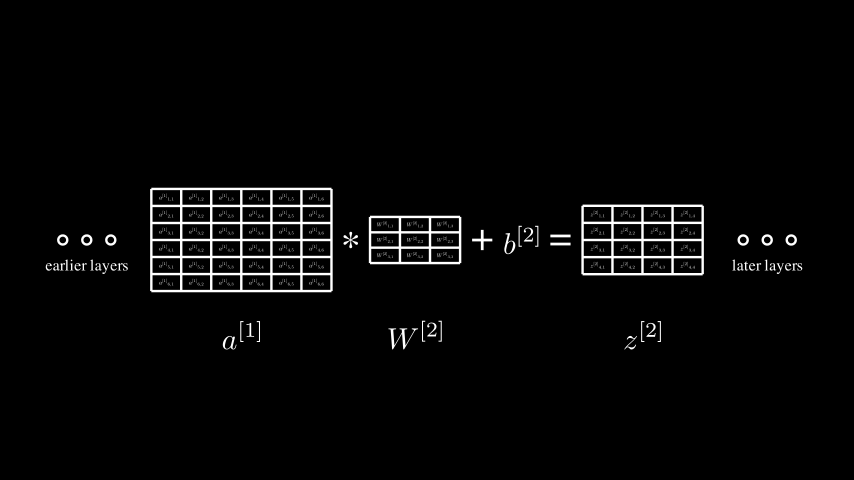

In [ ]:
#| echo: false
render_final_frame(NetworkDiagram)


For simplicity, I'm assuming $a^{[1]}$ has just one channel, there's just a single $W^{[2]}$ filter, and we're looking at just a single training example.
The following few lines of code implement the forward pass calculation of $z^{[2]}$ for our layer of interest:

In [ ]:
a1 = ndarray_of_indexed_base(IndexedBase(r'a^{[1]}'), (6, 6))
W2 = ndarray_of_indexed_base(IndexedBase(r'W^{[2]}'), (3, 3))
b2 = symbols(r'b^{[2]}')
z2 = convolve(a1, W2, 0, 1) + b2

We can examine the elements of `z2` to see that they represent the expressions we'd expect. E.g., the first element is:

In [ ]:
z2[0][0]

b^{[2]} + W^{[2]}[1, 1]*a^{[1]}[1, 1] + W^{[2]}[1, 2]*a^{[1]}[1, 2] + W^{[2]}[1, 3]*a^{[1]}[1, 3] + W^{[2]}[2, 1]*a^{[1]}[2, 1] + W^{[2]}[2, 2]*a^{[1]}[2, 2] + W^{[2]}[2, 3]*a^{[1]}[2, 3] + W^{[2]}[3, 1]*a^{[1]}[3, 1] + W^{[2]}[3, 2]*a^{[1]}[3, 2] + W^{[2]}[3, 3]*a^{[1]}[3, 3]

This is exactly the sum of the weights multiplied by the corresponding elements in the left corner of the input matrix, plus the bias term. Similarly, the next element of `z2` contains the expression for the next convolution output (notice the $a^{[1]}$ column indices are shifted over by one):

In [ ]:
z2[0][1]

b^{[2]} + W^{[2]}[1, 1]*a^{[1]}[1, 2] + W^{[2]}[1, 2]*a^{[1]}[1, 3] + W^{[2]}[1, 3]*a^{[1]}[1, 4] + W^{[2]}[2, 1]*a^{[1]}[2, 2] + W^{[2]}[2, 2]*a^{[1]}[2, 3] + W^{[2]}[2, 3]*a^{[1]}[2, 4] + W^{[2]}[3, 1]*a^{[1]}[3, 2] + W^{[2]}[3, 2]*a^{[1]}[3, 3] + W^{[2]}[3, 3]*a^{[1]}[3, 4]

If we wanted to visualize this expression, one way to do it would be to draw the three matrices, $a^{[1]}$, $W^{[2]}$, and $z^{[2]}$, and highlight the elements of $a^{[1]}$ and $W^{[2]}$ that are multiplied together to produce a given element of $z^{[2]}$. 

In [ ]:
#| code-fold: true

class HardCodedHighlights(Scene):
    def construct(self):
        # Construct matrices and do the convolution
        a1 = ndarray_of_indexed_base(IndexedBase(r'a^{[1]}'), (6, 6))
        W2 = ndarray_of_indexed_base(IndexedBase(r'W^{[2]}'), (3, 3))
        b2 = symbols(r'b^{[2]}')
        z2 = convolve(a1, W2, 0, 1) + b2

        a1_view, W2_view, z2_view = draw_convolution_operation(
            scene=self,
            a1=a1,
            W2=W2,
            z2=ndarray_of_indexed_base(IndexedBase(r'z^{[2]}'), z2.shape)
        )

        # Map matrix names to views
        array_to_view_map = {
            r'a^{[1]}': a1_view,
            r'W^{[2]}': W2_view,
            r'z^{[2]}': z2_view,
        }

        # Map of cells to highlight
        highlights_map = {
            r'W^{[2]}': [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)], 
            r'a^{[1]}': [(1, 2), (1, 3), (1, 4), (2, 2), (2, 3), (2, 4), (3, 2), (3, 3), (3, 4)],
        }

        # Highlight cells in the highlight map
        for matrix, cell_list in highlights_map.items():
            view = array_to_view_map[matrix]
            for cell in cell_list:
                highlight = view.get_cell(cell, color=YELLOW).scale(0.7)
                self.add(highlight)

        # Highlight the output cell
        self.add(z2_view.get_highlighted_cell((1, 2), color=TEAL_A))


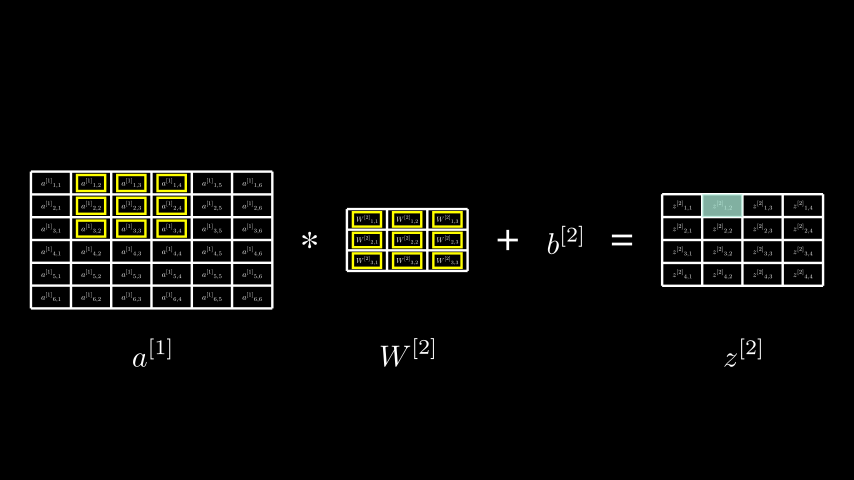

In [ ]:
#| echo: false
render_final_frame(HardCodedHighlights)

>In this visualization and all the others that follow, the "output element" (the element of the convolution result being computed) is highlighted in teal, and the elements of the inputs being multiplied together are outlined in yellow. In the example above, to compute element $z^{[2]}_{1, 2}$ (highlighted in teal), we multiply the elements of $W^{[2]}$ with the elements of $a^{[1]}$ outlined in yellow. 

In the code that generated this image, I hardcoded the cells to highlight:

```python
        # Map of cells to highlight
        highlights_map = {
            r'W^{[2]}': [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)], 
            r'a^{[1]}': [(1, 2), (1, 3), (1, 4), (2, 2), (2, 3), (2, 4), (3, 2), (3, 3), (3, 4)],
        }
```

It turns out we can generate this highlights map directly from an expression like:

$$
{W^{[2]}}_{1,1} {a^{[1]}}_{1,2} + {W^{[2]}}_{1,2} {a^{[1]}}_{1,3} + {W^{[2]}}_{1,3} {a^{[1]}}_{1,4} + {W^{[2]}}_{2,1} {a^{[1]}}_{2,2} + {W^{[2]}}_{2,2} {a^{[1]}}_{2,3} + {W^{[2]}}_{2,3} {a^{[1]}}_{2,4} + {W^{[2]}}_{3,1} {a^{[1]}}_{3,2} + {W^{[2]}}_{3,2} {a^{[1]}}_{3,3} + {W^{[2]}}_{3,3} {a^{[1]}}_{3,4}
$$

Because that expression is also a data structure. SymPy represents expressions as trees: details are in the [documentation](https://docs.sympy.org/latest/tutorials/intro-tutorial/manipulation.html) but the basic idea is that every expression object has a `func` attribute and an `args` attribute that (roughly) correspond to the operator and operands respectively. A few examples:

In [ ]:
x = Symbol('x')
expr = 2 + x

# The expressions's `func` is Add
test_eq(expr.func, Add)

# It's `args` are 2 and x
test_eq(expr.args, (2, x))

Using `func` and `args` to reflect over expressions, we can write a function that takes an expression and returns a dictionary where the keys are matrix names, and the values are lists of indices to highlight. 

In [ ]:
def build_highlights_map(expr: Expr) -> Dict[str, List[Tuple]]:
    # The expression needs to be either a sum of products or a single product
    assert expr.func == Add or expr.func == Mul

    # If it's an Add, assert all args are Muls
    if expr.func == Add:
        assert all(arg.func == Mul for arg in expr.args)

    # We want the list of multiplications. This is either a list consisting
    # of just the expression itself if it's a Mul or its arguments if it's
    # an Add.
    muls = [expr] if expr.func == Mul else expr.args

    results = {}
    for expr in muls:
        # Assert all the args are Indexed
        assert all(arg.func == Indexed for arg in expr.args)

        for indexed in expr.args:
            if indexed.base.name not in results:
                results[indexed.base.name] = []
            results[indexed.base.name].append(indexed.indices)    
    return results

This function makes a lot of assumptions that it's dealing with expressions that are just sums of products of `Indexed` objects, but it suffices for now. We can test it with one of the expressions in the `z2` array:

In [ ]:
build_highlights_map(z2[0][1]-b2) # Subtract off b2 because we aren't interested in the bias term for now.

{'W^{[2]}': [(1, 1),
  (1, 2),
  (1, 3),
  (2, 1),
  (2, 2),
  (2, 3),
  (3, 1),
  (3, 2),
  (3, 3)],
 'a^{[1]}': [(1, 2),
  (1, 3),
  (1, 4),
  (2, 2),
  (2, 3),
  (2, 4),
  (3, 2),
  (3, 3),
  (3, 4)]}

Now, we can incorporate that into a Manim scene and add some animation to go through all of the expressions in `z2`.

In [ ]:
# | code-fold: true

# Some config knobs for the animations
FADE_IN_TIME = 0.5
FADE_OUT_TIME = 0.3
WAIT_TIME = 0.5

# Turn build_highlights_map into a ufunc
build_highlights_map_ufunc = np.frompyfunc(build_highlights_map, 1, 1)


# Helper function to do the animation
def animate_highlights_map(
    scene: Scene,
    highlight_maps: np.ndarray,
    output_view: Mobject,
    array_to_view_map: Dict[str, Mobject],
):
    h, w = highlight_maps.shape
    for i in range(h):
        for j in range(w):
            highlight = output_view.get_highlighted_cell((i + 1, j + 1), color=TEAL_A)
            anims_in = [FadeIn(highlight, run_time=FADE_IN_TIME)]
            anims_out = [FadeOut(highlight, run_time=FADE_OUT_TIME)]

            for matrix, cell_list in highlight_maps[i][j].items():
                view = array_to_view_map[matrix]
                for cell in cell_list:
                    highlight = view.get_cell(cell, color=YELLOW).scale(0.7)

                    anims_in.append(FadeIn(highlight, run_time=FADE_IN_TIME))
                    anims_out.append(FadeOut(highlight, run_time=FADE_IN_TIME))

            scene.play(*anims_in)
            scene.wait(WAIT_TIME)
            scene.play(*anims_out)


class ConvolutionForward(Scene):
    def construct(self):
        # Construct matrices and do the convolution
        a1 = ndarray_of_indexed_base(IndexedBase(r'a^{[1]}'), (6, 6))
        W2 = ndarray_of_indexed_base(IndexedBase(r'W^{[2]}'), (3, 3))
        b2 = symbols(r'b^{[2]}')
        z2 = convolve(a1, W2, 0, 1) + b2

        a1_view, W2_view, z2_view = draw_convolution_operation(
            scene=self,
            a1=a1,
            W2=W2,
            z2=ndarray_of_indexed_base(IndexedBase(r'z^{[2]}'), z2.shape),
        )

        # Map matrix names to views
        array_to_view_map = {
            r'a^{[1]}': a1_view,
            r'W^{[2]}': W2_view,
            r'z^{[2]}': z2_view,
        }

        # Build highlight map for all elements of z2
        highlight_maps = build_highlights_map_ufunc(z2 - b2)

        animate_highlights_map(self, highlight_maps, z2_view, array_to_view_map)

In [ ]:
# | echo: false
render_video(ConvolutionForward)

This produces a video. To keep the notebook small, I've not embedded it directly, but the YouTube version below shows the output. This is a working animation of a convolution, generated directly from the expressions used to compute it. 

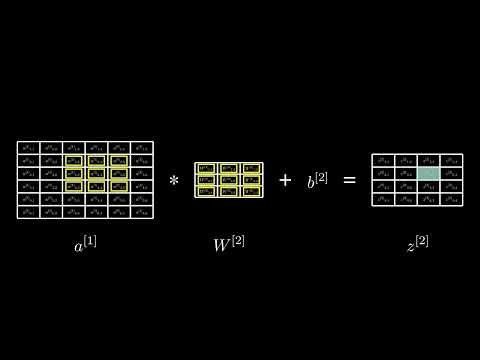

In [ ]:
#| echo: false
video_id = 'Y7eoO3hZQYY'
YouTubeVideo(video_id, allow_autoplay=True, loop=1, mute=1, playlist=video_id)

### Other Forms of Convolution
Because the drawing logic is driven purely off the expressions, it's trivial to visualize other forms of the convolution. For example, if we wanted to see what it looks like with padding set to 2 (making this a [full convolution](https://ai.stackexchange.com/a/27780)), we'd just need to change the value of the `zero_pad_width` param in the call to `convolve()` and everything else* works the same:

In [ ]:
# | code-fold: true

class FullConvolutionForward(Scene):
    def construct(self):
        # Construct matrices and do the convolution
        a1 = ndarray_of_indexed_base(IndexedBase(r'a^{[1]}'), (6, 6))
        W2 = ndarray_of_indexed_base(IndexedBase(r'W^{[2]}'), (3, 3))
        b2 = symbols(r'b^{[2]}')
        z2 = convolve(a1, W2, W2.shape[0] - 1, 1) + b2

        a1_view, W2_view, z2_view = draw_convolution_operation(
            scene=self,
            a1=a1,
            W2=W2,
            z2=ndarray_of_indexed_base(IndexedBase(r'z^{[2]}'), z2.shape),
            intra_item_buffer=0.2
        )

        # Map matrix names to views
        array_to_view_map = {
            r'a^{[1]}': a1_view,
            r'W^{[2]}': W2_view,
            r'z^{[2]}': z2_view,
        }

        # Build highlight map for all elements of z2
        highlight_maps = build_highlights_map_ufunc(z2 - b2)

        animate_highlights_map(self, highlight_maps, z2_view, array_to_view_map)
    

In [ ]:
# | echo: false
render_video(FullConvolutionForward)

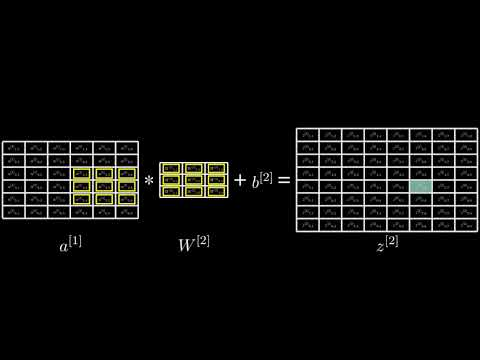

In [ ]:
#| echo: false
video_id = 'Svs0BM8Gsok'
YouTubeVideo(video_id, allow_autoplay=True, loop=1, mute=1, playlist=video_id)

>*Well, one small change was needed: in order to accommodate the larger output matrix, I reduced the spacing between the objects. But nothing else in the drawing logic changed. 

This doesn't show the padding on $a^{[1]}$ - remember that it's just highlighting which cells are multiplied together - but this is enough to see the effect of the padding. It's like $W^{[2]}$ starts positioned so that only it's bottom-right element overlaps with the top-left element of $a^{[1]}$, and then progresses to the right, then down, all the way until only its top-right element is overlaid with $a^{[1]}$'s bottom-right element. 

The change to the `zero_pad_width` parameter to `convolve()` resulted in different expressions in the output matrix and the visualization code simply rendered those. 

## Reality Check

At this point, I hope at least some readers think this is cool. But others of you may be thinking, "Hang on. You ran a process that recorded its steps in a data structure (albeit a weird one), then you pulled out those steps from the data structure and replayed them visually. You could have just made the convolution code output the highlights map directly and skipped the expression stuff altogether."

This is fair. But, the special thing about using expressions is that SymPy knows how to do calculus and it can differentiate those expressions for us. Please hold for what comes next.

## Backprop through Convolutions

The calculation of $z^{[2]}$ we've looked at so far is part of the forward pass of a CNN. In the rest of the forward pass, $z^{[2]}$ will typically go through a non-linear activation function, $g^{[2]}()$, to produce $a^{[2]}$, which would propagate through potentially more layers to the end of the network, producing a final output, $\hat{y}$. 


In [ ]:
# | code-fold: true


class RestOfForwardPassDiagram(Scene):
    def construct(self):
        z2 = ndarray_of_indexed_base(IndexedBase(r'z^{[2]}'), (4, 4))
        a2 = ndarray_of_indexed_base(IndexedBase(r'a^{[2]}'), (4, 4))

        z2_view = create_math_table(z2, cell_size=(0.25, 0.5))
        a2_view = create_math_table(a2, cell_size=(0.25, 0.5))
        after_ellipsis = create_ellipsis()
        self.add(
            VGroup(
                MathTex('g^{[2]}('),
                z2_view,
                MathTex(') = '),
                a2_view,
                Text('#').scale(0.2).set_opacity(0),  # space
                after_ellipsis,
                Arrow(start=LEFT, end=RIGHT),
                MathTex('\hat{y}'),
            ).arrange(direction=RIGHT),
        )

        self.add(MathTex('z^{[2]}').next_to(z2_view, direction=DOWN, buff=0.25))

        self.add(MathTex('a^{[2]}').next_to(a2_view, direction=DOWN, buff=0.25))

        self.add(
            Text("later layers")
            .scale(0.4)
            .next_to(after_ellipsis, direction=DOWN, buff=0.25)
        )

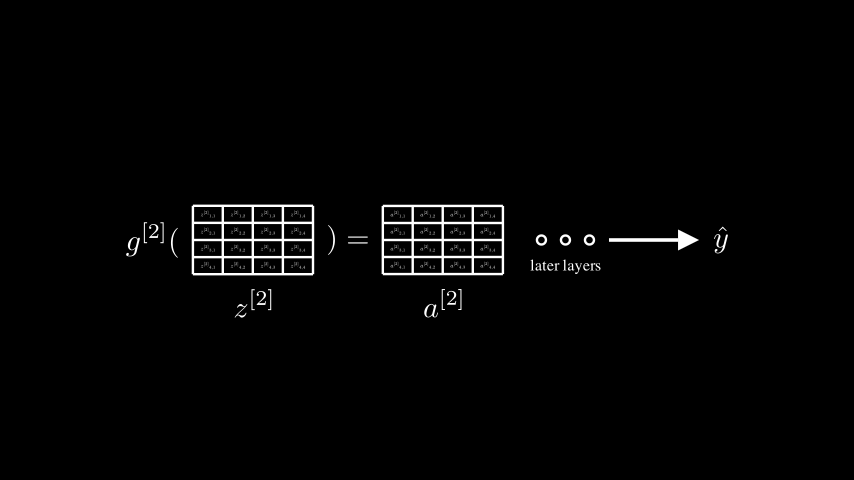

In [ ]:
# | echo: false
render_final_frame(RestOfForwardPassDiagram)


To start the backward pass, we'd evaluate the loss function ($\mathcal{L}(y, \hat{y})$) and use the chain rule to propagate the loss backwards through the layers. My CNN class didn't derive the backprop equations for convolutional layers - my attempting to do that on my own led to this whole investigation. It turns out that the approach of using symbols in the convolution matrices makes it really easy to not only derive the backprop equations but also visualize them. 

Because we haven't defined what the later layers look like, we have to take on faith that someone has done the work to back-propagate the loss gradient through them and has handed us $\frac{\partial \mathcal{L}}{\partial z^{[2]}}$. Now need to compute $\frac{\partial \mathcal{L}}{\partial W^{[2]}}$, $\frac{\partial \mathcal{L}}{\partial b^{[2]}}$, and $\frac{\partial \mathcal{L}}{\partial a^{[1]}}$.

Let's start with $\frac{\partial \mathcal{L}}{\partial W^{[2]}}$: the gradient of the loss with respect to the weights in the convolution filter, $W^{[2]}$. 

### Deriving $\frac{\partial \mathcal{L}}{\partial W^{[2]}}$

The backprop process through all the layers $\mathcal{l}$ for $\mathcal{l} > 2$ has given us:

$$
\frac{\partial \mathcal{L}}{\partial z^{[2]}} =
\def\arraystretch{1.5}
\begin{bmatrix}
\frac{\partial \mathcal{L}}{\partial z^{[2]}_{11}} & \frac{\partial \mathcal{L}}{\partial z^{[2]}_{12}} & \frac{\partial \mathcal{L}}{\partial z^{[2]}_{13}} & \frac{\partial \mathcal{L}}{\partial z^{[2]}_{14}}\\
\frac{\partial \mathcal{L}}{\partial z^{[2]}_{21}} & \frac{\partial \mathcal{L}}{\partial z^{[2]}_{22}} & \frac{\partial \mathcal{L}}{\partial z^{[2]}_{23}} & \frac{\partial \mathcal{L}}{\partial z^{[2]}_{24}}\\
\frac{\partial \mathcal{L}}{\partial z^{[2]}_{31}} & \frac{\partial \mathcal{L}}{\partial z^{[2]}_{32}} & \frac{\partial \mathcal{L}}{\partial z^{[2]}_{33}} & \frac{\partial \mathcal{L}}{\partial z^{[2]}_{34}}\\
\frac{\partial \mathcal{L}}{\partial z^{[2]}_{41}} & \frac{\partial \mathcal{L}}{\partial z^{[2]}_{42}} & \frac{\partial \mathcal{L}}{\partial z^{[2]}_{43}} & \frac{\partial \mathcal{L}}{\partial z^{[2]}_{44}}\\
\end{bmatrix}
$$

and now we want to calculate:

$$
\frac{\partial \mathcal{L}}{\partial W^{[2]}} =
\def\arraystretch{1.5}
\begin{bmatrix}
\frac{\partial \mathcal{L}}{\partial W^{[2]}_{11}} & \frac{\partial \mathcal{L}}{\partial W^{[2]}_{12}} & \frac{\partial \mathcal{L}}{\partial W^{[2]}_{13}}\\
\frac{\partial \mathcal{L}}{\partial W^{[2]}_{21}} & \frac{\partial \mathcal{L}}{\partial W^{[2]}_{22}} & \frac{\partial \mathcal{L}}{\partial W^{[2]}_{23}}\\
\frac{\partial \mathcal{L}}{\partial W^{[2]}_{31}} & \frac{\partial \mathcal{L}}{\partial W^{[2]}_{32}} & \frac{\partial \mathcal{L}}{\partial W^{[2]}_{33}}\\
\end{bmatrix}
$$

Each element of $\frac{\partial \mathcal{L}}{\partial W^{[2]}}$ represents the gradient of the loss function $\mathcal{L}$ with respect to the corresponding element of $W^{[2]}$. Because $z^{[2]} = a^{[1]} * W^{[2]} + b^{[2]}$, each element of $W^{[2]}$ contributes to every element of $z^{[2]}$. 


In [ ]:
# | code-fold: true


class ComputationGraphWtoZ(Scene):
    def construct(self):
        z11 = MathTex(r'z^{[2]}_{1, 1}')
        z12 = MathTex(r'z^{[2]}_{1, 2}')
        z43 = MathTex(r'z^{[2]}_{4, 3}')
        z44 = MathTex(r'z^{[2]}_{4, 4}')

        zs = VGroup(
            z11,
            z12,
            Text("."),
            Text("."),
            Text("."),
            z43,
            z44,
        ).arrange(direction=DOWN)

        W11 = MathTex(r'W^{[2]}_{1, 1}')
        W12 = MathTex(r'W^{[2]}_{1, 2}')
        W32 = MathTex(r'W^{[2]}_{3, 2}')
        W33 = MathTex(r'W^{[2]}_{3, 3}')
        Ws = VGroup(
            W11,
            W12.set_opacity(0.6),
            Text(".").set_opacity(0.6),
            Text(".").set_opacity(0.6),
            Text(".").set_opacity(0.6),
            W32.set_opacity(0.6),
            W33.set_opacity(0.6),
        ).arrange(direction=DOWN)

        loss = MathTex('\mathcal{L}').scale(1.5)

        later_layers = VGroup(
            Rectangle(
                width=1.75,
                height=3.0,
                fill_color=BLACK,
                fill_opacity=1.0,
                stroke_width=0.0,
            ),
            VGroup(create_ellipsis(), Text("later layers").scale(0.4)).arrange(
                direction=DOWN
            ),
        )

        self.add(
            VGroup(
                Ws,
                zs,
                later_layers,
                loss,
            ).arrange(direction=RIGHT, buff=2.5),
        )

        for z in [z11, z12, z43, z44]:
            self.add(
                Arrow(
                    start=W11.get_right(),
                    end=z.get_left(),
                    max_tip_length_to_length_ratio=0.05,
                    max_stroke_width_to_length_ratio=0.5,
                )
            )

            self.add(
                Arrow(
                    start=z.get_right(),
                    end=loss.get_left(),
                    max_tip_length_to_length_ratio=0.025,
                    max_stroke_width_to_length_ratio=0.5,
                )
            )

        # Make the "later layers" depiction appear in front of the arrows
        self.add_foreground_mobject(later_layers)

        for W in [W12, W32, W33]:
            for z in [z11, z12, z43, z44]:
                self.add(
                    Arrow(
                        start=W.get_right(),
                        end=z.get_left(),
                        max_tip_length_to_length_ratio=0.05,
                        max_stroke_width_to_length_ratio=0.5,
                    ).set_opacity(0.2)
                )

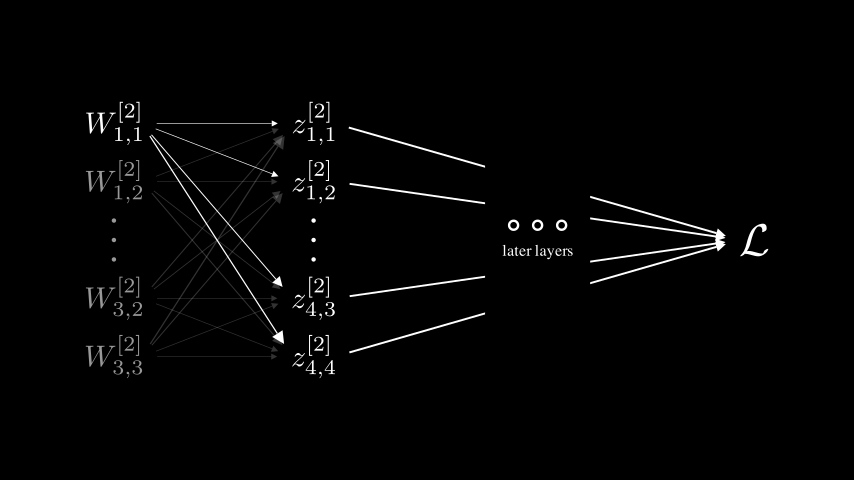

In [ ]:
# | echo: false
render_final_frame(ComputationGraphWtoZ)


Let's consider $\frac{\partial \mathcal{L}}{\partial W^{[2]}_{11}}$, the loss gradient with respect to the first element of $W^{[2]}$. For each element $z^{[2]}_{k, l}$ of $z^{[2]}$:

* We know $\frac{\partial \mathcal{L}}{\partial z^{[2]}_{k, l}}$ (gradient of the loss with respect to $z^{[2]}_{k, l}$)
* We can compute $\frac{\partial z^{[2]}_{k, l}}{\partial W^{[2]}_{11}}$ (gradient of $z^{[2]}_{k, l}$ with respect to $W^{[2]}_{11}$)

The chain rule says we can multiply these together:

$$
\frac{\partial \mathcal{L}}{\partial z^{[2]}_{k, l}}\frac{\partial z^{[2]}_{k, l}}{\partial W^{[2]}_{11}}
$$

and this will give us the portion of $\frac{\partial \mathcal{L}}{\partial W^{[2]}_{11}}$ resulting from $W^{[2]}_{11}$'s contribution to $z^{[2]}_{k, l}$. If we want the total $\frac{\partial \mathcal{L}}{\partial W^{[2]}_{11}}$ we just need to sum this across all elements $z^{[2]}_{k, l}$ of $z^{[2]}$:

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial W^{[2]}_{11}} &= \sum_{k, l} \frac{\partial \mathcal{L}}{\partial z^{[2]}_{k, l}}\frac{\partial z^{[2]}_{k, l}}{\partial W^{[2]}_{11}}\\[2em]
&= \frac{\partial \mathcal{L}}{\partial z^{[2]}_{11}}\frac{\partial z^{[2]}_{11}}{\partial W^{[2]}_{11}} + \frac{\partial \mathcal{L}}{\partial z^{[2]}_{12}}\frac{\partial z^{[2]}_{12}}{\partial W^{[2]}_{11}} + \cdots + \frac{\partial \mathcal{L}}{\partial z^{[2]}_{44}}\frac{\partial z^{[2]}_{44}}{\partial W^{[2]}_{11}} 
\end{align}
$$


Or, more generally, for each element $W^{[2]}_{i, j}$ of $W^{[2]}$:

$$
\frac{\partial \mathcal{L}}{\partial W^{[2]}_{i, j}} = \sum_{k, l} \frac{\partial \mathcal{L}}{\partial z^{[2]}_{k, l}}\frac{\partial z^{[2]}_{k, l}}{\partial W^{[2]}_{i, j}}
$$

We could of course work out by hand what this would be. But we've got a whole symbolic engine at our disposal - lets use it instead!


SymPy has the ability to differentiate symbolic expressions (and other [calculus abilities](https://docs.sympy.org/latest/tutorials/intro-tutorial/calculus.html)). Here's a quick showcase: let's create a symbolic expression for: $x = 2y^2 + 3z$ and then differentiate with respect to $y$:

In [ ]:
x, y, z = symbols('x y z')
x = 2*y**2 + 3*z 
x.diff(y)

4*y

The answer, $4y$, is of course what we expect. In the computation of $\frac{\partial \mathcal{L}}{\partial W^{[2]}}$, we know we're going to need $\frac{\partial z^{[2]}_{k, l}}{\partial W^{[2]}_{i, j}}$. Our `z2` matrix already contains the expressions for each element of $z^{[2]}$. E.g. $z^{[2]}_{1, 1}$ is:

In [ ]:
z2[0][0]

b^{[2]} + W^{[2]}[1, 1]*a^{[1]}[1, 1] + W^{[2]}[1, 2]*a^{[1]}[1, 2] + W^{[2]}[1, 3]*a^{[1]}[1, 3] + W^{[2]}[2, 1]*a^{[1]}[2, 1] + W^{[2]}[2, 2]*a^{[1]}[2, 2] + W^{[2]}[2, 3]*a^{[1]}[2, 3] + W^{[2]}[3, 1]*a^{[1]}[3, 1] + W^{[2]}[3, 2]*a^{[1]}[3, 2] + W^{[2]}[3, 3]*a^{[1]}[3, 3]

 We can use the same `diff()` method shown above to compute the derivivatives with respect to the elements of $W^{[2]}$. E.g., here's $\frac{\partial z^{[2]}_{1, 1}}{\partial W^{[2]}_{1, 1}}$

In [ ]:
z2[0][0].diff(W2[0][0])

a^{[1]}[1, 1]

We could now write some code to compute each element of $\frac{\partial \mathcal{L}}{\partial W^{[2]}}$ according to the by applying the chain rule with each element of $\frac{\partial \mathcal{L}}{\partial z^{[2]}}$ and summing, as we worked out above. But we're going to need similar logic in other cases, so let's write a more general-purpose function we can re-use. 

Let `A` and `B` be matrices of symbols and `df_dA` also be a matrix of symbols representing $\frac{\partial f}{\partial A}$. The function below computes $\frac{\partial f}{\partial B}$ by applying the chain rule element-wise:

For every $i, j$ in $B$, the function calculates 

$$
\frac{\partial f}{\partial B_{i, j}} = \sum_{k, l} \frac{\partial f}{\partial A_{k, l}}\frac{\partial A_{k, l}}{\partial B_{i, j}}
$$

In [ ]:
def matrix_matrix_chain_rule(df_dA: np.ndarray, A: np.ndarray, B: np.ndarray):
    """
    Say f is a function, A & B are matrices represented by ndarrays
    Given an matrix of the elements of df/dA, A, and B, this function
    computes the elements of df_dB by applying the chain rule element-
    wise.
    """
    Ah, Aw = A.shape
    Bh, Bw = B.shape

    output = np.array(
        [
            [
                sum(
                    [
                        df_dA[ak][al] * A[ak][al].diff(B[bi][bj])
                        for ak in range(Ah)
                        for al in range(Aw)
                    ]
                )
                for bj in range(Bw)
            ]
            for bi in range(Bh)
        ],
        dtype=object,
    )

    return output

Now, let's use our symbolic engine and our `matrix_matrix_chain_rule()` function to work out $\frac{\partial \mathcal{L}}{\partial W^{[2]}}$. 

In [ ]:
# Describe the loss function symbolically
y = symbols('y')
yhat = symbols(r'\hat{y}')
L = Function(r'\mathcal{L}')(y, yhat)

# Build dL/dz2
dz2 = ndarray_of_indexed_base(
    IndexedBase(r'z^{[2]}'), z2.shape, transform=lambda x: Derivative(L, x)
)

dW2 = matrix_matrix_chain_rule(dz2, z2, W2)

Markdown(matrix_to_markdown(dW2))

$$\begin{bmatrix}
\frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{1,1} + \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{1,2} + \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{1,3} + \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{1,4} + \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,1} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,4} + \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,1} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,4} + \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,1} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,2} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,3} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,4} & \frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{1,2} + \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{1,3} + \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{1,4} + \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{1,5} + \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,4} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,5} + \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,4} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,5} + \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,2} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,3} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,4} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,5} & \frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{1,3} + \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{1,4} + \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{1,5} + \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{1,6} + \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,4} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,5} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,6} + \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,4} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,5} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,6} + \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,3} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,4} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,5} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,6}\\
\frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,1} + \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,4} + \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,1} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,4} + \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,1} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,2} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,3} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,4} + \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,1} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,2} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,3} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,4} & \frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,4} + \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,5} + \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,4} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,5} + \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,2} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,3} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,4} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,5} + \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,2} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,3} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,4} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,5} & \frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,4} + \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,5} + \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{2,6} + \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,4} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,5} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,6} + \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,3} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,4} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,5} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,6} + \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,3} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,4} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,5} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,6}\\
\frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,1} + \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,4} + \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,1} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,2} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,3} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,4} + \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,1} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,2} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,3} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,4} + \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{6,1} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{6,2} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{6,3} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{6,4} & \frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,4} + \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,5} + \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,2} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,3} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,4} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,5} + \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,2} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,3} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,4} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,5} + \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{6,2} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{6,3} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{6,4} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{6,5} & \frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,4} + \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,5} + \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{3,6} + \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,3} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,4} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,5} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{4,6} + \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,3} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,4} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,5} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{5,6} + \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{6,3} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{6,4} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{6,5} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {a^{[1]}}_{6,6}\end{bmatrix}
$$

OK, we got a matrix, and each element of this is an expression. Before trying to dig into it, let's just visualize it. Each expression looks like a sum of products and so like before, we can build a highlight map from it, and use this to animate a diagram. But we do need to make one tiny change to `build_highlights_map()`, to make it deal with the derivatives of indexed objects.

In [ ]:
def build_highlights_map(expr: Expr) -> Dict[str, List[Tuple]]:
    # The expression needs to be either a sum of products or a single product
    assert expr.func == Add or expr.func == Mul

    # If it's an Add, assert all args are Muls
    if expr.func == Add:
        assert all(arg.func == Mul for arg in expr.args)

    # We want the list of multiplications. This is either a list consisting
    # of just the expression itself if it's a Mul or its arguments if it's
    # an Add.
    muls = [expr] if expr.func == Mul else expr.args

    results = {}
    for expr in muls:
        # Assert all the args are Indexed or derivatives w.r.t. an Indexed
        assert all(
            arg.func == Indexed
            or (arg.func == Derivative and arg.args[1][0].func == Indexed)
            for arg in expr.args
        )

        indexeds = [arg if arg.func == Indexed else arg.args[1][0] for arg in expr.args]

        for indexed in indexeds:
            if indexed.base.name not in results:
                results[indexed.base.name] = []
            results[indexed.base.name].append(indexed.indices)
    return results

We can now use this version of `build_highlights_map()` in drawing code to visualize the operations used to compute $\frac{\partial \mathcal{L}}{\partial W^{[2]}}$. The result is the video below. 

In [ ]:
# | code-fold: true

# Recreate ufunc for build_highlights_map now that we've updated it
build_highlights_map_ufunc = np.frompyfunc(build_highlights_map, 1, 1)


def draw_matrices(
    scene: Scene, matrices_and_labels: Iterable[Tuple[np.ndarray, Mobject]]
):
    cell_size = (0.38, 0.67)
    # Create wrapper so we don't have to type cell_size in every call
    math_table = lambda arr: create_math_table(arr, cell_size)

    views_and_labels = [(math_table(m), label) for m, label in matrices_and_labels]
    views = [view for view, _ in views_and_labels]
    arrange_items_and_labels(
        scene=scene,
        items=views,
        labels=views_and_labels,
    )
    return tuple(views)


class BackPropDW2(Scene):
    def construct(self):
        # Create a1, W2, and convolve them:
        a1 = ndarray_of_indexed_base(IndexedBase(r'a^{[1]}'), (6, 6))
        W2 = ndarray_of_indexed_base(IndexedBase(r'W^{[2]}'), (3, 3))
        b2 = symbols(r'b^{[2]}')
        z2 = convolve(a1, W2, 0, 1) + b2

        # Set up the loss function symbolically.
        y = symbols('y')
        yhat = symbols(r'\hat{y}')
        L = Function(r'\mathcal{L}')(y, yhat)

        # Build dL/dz2
        dz2 = ndarray_of_indexed_base(
            IndexedBase(r'z^{[2]}'), z2.shape, transform=lambda x: Derivative(L, x)
        )

        # Build dL/dW2
        dW2 = ndarray_of_indexed_base(
            IndexedBase(r'W^{[2]}'),
            W2.shape,
            transform=lambda x: Derivative(L, x),
        )

        # Do the calculation to get the expressions for dW2
        dW2_expr = matrix_matrix_chain_rule(dz2, z2, W2)

        a1_view, dz2_view, dW2_view = draw_matrices(
            scene=self,
            matrices_and_labels=[
                (a1, MathTex(r'a^{[1]}')),
                (dz2, MathTex(r'\frac{\partial \mathcal{L}}{\partial z^{[2]}}')),
                (
                    dW2,
                    MathTex(r'\frac{\partial \mathcal{L}}{\partial W^{[2]}}'),
                ),
            ],
        )

        # Map matrix names to views
        array_to_view_map = {
            r'a^{[1]}': a1_view,
            r'W^{[2]}': dW2_view,
            r'z^{[2]}': dz2_view,
        }

        # Build highlight maps
        highlight_maps = build_highlights_map_ufunc(dW2_expr)

        animate_highlights_map(self, highlight_maps, dW2_view, array_to_view_map)

In [ ]:
# | echo: false
render_video(BackPropDW2)

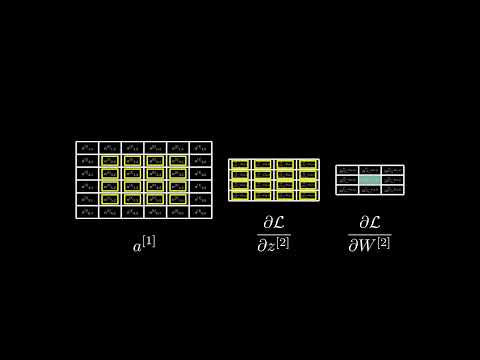

In [ ]:
#| echo: false
video_id = 'twJifMiFloA'
YouTubeVideo(video_id, allow_autoplay=True, loop=1, mute=1, playlist=video_id)

This looks a whole lot like a convolution of $a^{[1]}$ with $\frac{\partial \mathcal{L}}{\partial z^{[2]}}$. We can confirm this with the equations:

In [ ]:
display(dW2[0][0])

Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[1, 1])*a^{[1]}[1, 1] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[1, 2])*a^{[1]}[1, 2] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[1, 3])*a^{[1]}[1, 3] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[1, 4])*a^{[1]}[1, 4] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[2, 1])*a^{[1]}[2, 1] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[2, 2])*a^{[1]}[2, 2] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[2, 3])*a^{[1]}[2, 3] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[2, 4])*a^{[1]}[2, 4] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[3, 1])*a^{[1]}[3, 1] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[3, 2])*a^{[1]}[3, 2] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[3, 3])*a^{[1]}[3, 3] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[3, 4])*a^{[1]}[3, 4] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[4, 1])*a^{[1]}[4, 1] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[4, 2])*a^{[1]}[4, 2] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[4, 3])*a^{[1]}[4, 

In [ ]:
display(dW2[1][0])

Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[1, 1])*a^{[1]}[2, 1] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[1, 2])*a^{[1]}[2, 2] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[1, 3])*a^{[1]}[2, 3] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[1, 4])*a^{[1]}[2, 4] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[2, 1])*a^{[1]}[3, 1] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[2, 2])*a^{[1]}[3, 2] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[2, 3])*a^{[1]}[3, 3] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[2, 4])*a^{[1]}[3, 4] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[3, 1])*a^{[1]}[4, 1] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[3, 2])*a^{[1]}[4, 2] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[3, 3])*a^{[1]}[4, 3] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[3, 4])*a^{[1]}[4, 4] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[4, 1])*a^{[1]}[5, 1] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[4, 2])*a^{[1]}[5, 2] + Derivative(\mathcal{L}(y, \hat{y}), z^{[2]}[4, 3])*a^{[1]}[5, 

Notice how in `dw2[0][0]` (which is $\frac{\partial \mathcal{L}}{\partial W^{[2]}_{11}}$) each element of $\frac{\partial \mathcal{L}}{\partial z^{[2]}}$ is multiplied by the corresponding element of $a^{[1]}$ and in `dw2[1][0]` ($\frac{\partial \mathcal{L}}{\partial w^{[2]}_{21}}$) all the indices of $a^{[1]}$ are shifted down by one, as you'd expect. 

But this is all so much easier to see in the visualization. Again, the visualization was generated from the expressions in `dW2`, not programmed based on some advanced knowledge of how it should look. In this way, it's actually more of a simulation than a visualization. 

So we can conclude that:

$$
\frac{\partial \mathcal{L}}{\partial W^{[2]}} = a^{[1]} * \frac{\partial \mathcal{L}}{\partial z^{[2]}}
$$

In code:

In [ ]:
test_eq(convolve(a1, dz2, 0, 1), dW2)

### Deriving $\frac{\partial \mathcal{L}}{\partial a^{[1]}}$

Next, let's work out $\frac{\partial \mathcal{L}}{\partial a^{[1]}}$, the gradient of the loss function with respect to the previous layer's activations. We can do this by applying the chain rule element-wise, as we did in the previous section: 

For each element $a^{[1]}_{i, j}$ of $a^{[1]}$:

$$
\frac{\partial \mathcal{L}}{\partial a^{[1]}_{i, j}} = \sum_{k, l} \frac{\partial \mathcal{L}}{\partial z^{[2]}_{k, l}}\frac{\partial z^{[2]}_{k, l}}{\partial a^{[1]}_{i, j}}
$$

And of course, we don't have to do this by hand.

In [ ]:
da1 = matrix_matrix_chain_rule(dz2, z2, a1)

Markdown(matrix_to_markdown(da1))

$$\begin{bmatrix}
\frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,1} & \frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,2} + \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,1} & \frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,3} + \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,2} + \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,1} & \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,3} + \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,2} + \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,1} & \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,3} + \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,2} & \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,3}\\
\frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,1} + \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,1} & \frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,1} + \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,2} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,1} & \frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,1} + \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,3} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,2} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,1} & \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,1} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,3} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,2} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,1} & \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,3} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,2} & \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,3}\\
\frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,1} + \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,1} + \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,1} & \frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,1} + \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,1} + \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,2} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,1} & \frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,1} + \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,1} + \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,3} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,2} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,1} & \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,1} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,1} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,3} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,2} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,1} & \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,3} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,2} & \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,3}\\
\frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,1} + \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,1} + \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,1} & \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,1} + \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,1} + \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,2} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,1} & \frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,1} + \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,1} + \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,3} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,2} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,1} & \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,1} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,1} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,3} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,2} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,1} & \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,3} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,2} & \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{1,3}\\
\frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,1} + \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,1} & \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,1} + \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,1} & \frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,1} + \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,1} & \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,1} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,2} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,1} & \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,3} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,2} & \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{2,3}\\
\frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,1} & \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,1} & \frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,1} & \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,2} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,1} & \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,3} + \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,2} & \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)} {W^{[2]}}_{3,3}\end{bmatrix}
$$

Again, an matrix of expressions and the shape looks interesting. Because these expressions are sums of products of indexed expressions, we can build a highlights map and visualize it. 

In [ ]:
# | code-fold: true
class BackPropDa1(Scene):
    def construct(self):
        # Create a1, W2, and convolve them:
        a1 = ndarray_of_indexed_base(IndexedBase(r'a^{[1]}'), (6, 6))
        W2 = ndarray_of_indexed_base(IndexedBase(r'W^{[2]}'), (3, 3))
        b2 = symbols(r'b^{[2]}')
        z2 = convolve(a1, W2, 0, 1) + b2

        # Set up the loss function symbolically.
        y = symbols('y')
        yhat = symbols(r'\hat{y}')
        L = Function(r'\mathcal{L}')(y, yhat)

        # Build dL/dz2
        dz2 = ndarray_of_indexed_base(
            IndexedBase(r'z^{[2]}'), z2.shape, transform=lambda x: Derivative(L, x)
        )

        # Build dL/da1
        da1 = ndarray_of_indexed_base(
            IndexedBase(r'a^{[1]}'), a1.shape, transform=lambda x: Derivative(L, x)
        )

        # Do the calculation to get the expressions for da1
        da1_expr = matrix_matrix_chain_rule(dz2, z2, a1)

        dz2_view, W2_view, da1_view = draw_matrices(
            scene=self,
            matrices_and_labels=[
                (dz2, MathTex(r'\frac{\partial \mathcal{L}}{\partial z^{[2]}}')),
                (W2, MathTex(r'W^{[2]}')),
                (da1, MathTex(r'\frac{\partial \mathcal{L}}{\partial a^{[1]}}')),
            ],
        )

        # Map matrix names to views
        array_to_view_map = {
            r'a^{[1]}': da1_view,
            r'W^{[2]}': W2_view,
            r'z^{[2]}': dz2_view,
        }

        # Build highlight maps
        highlight_maps = build_highlights_map_ufunc(da1_expr)

        animate_highlights_map(self, highlight_maps, da1_view, array_to_view_map)

In [ ]:
# | echo: false
render_video(BackPropDa1)

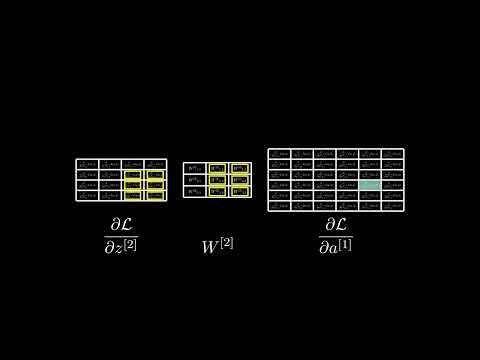

In [ ]:
#| echo: false
video_id = 'oZ9CKJ1gYls'
YouTubeVideo(video_id, allow_autoplay=True, loop=1, mute=1, playlist=video_id)

Like in other examples, I've put the inputs on the left and middle and the output ($\frac{\partial \mathcal{L}}{\partial a^{[1]}}$) on the right. This is not quite a straight convolution like we saw in $\frac{\partial \mathcal{L}}{\partial W^{[2]}}$, but it does look somewhat reminiscient of the full convolution (convolution with padding) we looked at in the [Other Forms of Convolution](#other-forms-of-convolution) section. Only, it's sort of backwards. Whereas in the full convolution, the multiplications start with the bottom-right corner of the convolution filter, here they start at the top-left. We could make this match by rotating $W^{[2]}$ by 180°.

In [ ]:
# | code-fold: true
class BackPropDa1WithRotation(Scene):
    def construct(self):
        # Create a1, W2, and convolve them:
        a1 = ndarray_of_indexed_base(IndexedBase(r'a^{[1]}'), (6, 6))
        W2 = ndarray_of_indexed_base(IndexedBase(r'W^{[2]}'), (3, 3))
        b2 = symbols(r'b^{[2]}')
        z2 = convolve(a1, W2, 0, 1) + b2

        # Set up the loss function symbolically.
        y = symbols('y')
        yhat = symbols(r'\hat{y}')
        L = Function(r'\mathcal{L}')(y, yhat)

        # Build dL/dz2
        dz2 = ndarray_of_indexed_base(
            IndexedBase(r'z^{[2]}'), z2.shape, transform=lambda x: Derivative(L, x)
        )

        # Build dL/da1
        da1 = ndarray_of_indexed_base(
            IndexedBase(r'a^{[1]}'), a1.shape, transform=lambda x: Derivative(L, x)
        )

        # Do the calculation to get the expressions for da1
        da1_expr = matrix_matrix_chain_rule(dz2, z2, a1)

        dz2_view, W2_view, da1_view = draw_matrices(
            scene=self,
            matrices_and_labels=[
                (dz2, MathTex(r'\frac{\partial \mathcal{L}}{\partial z^{[2]}}')),
                (W2, MathTex(r'W^{[2]}')),
                (da1, MathTex(r'\frac{\partial \mathcal{L}}{\partial a^{[1]}}')),
            ],
        )

        # Rotate W2 and draw a curved arrow to indicate the rotation
        radius = 0.3  # radius of the curved arrow
        angle = PI  # angle the arrow (and W2) should rotate through
        arrow_end = W2_view.get_critical_point(DOWN) + np.array(
            [0, -0.9, 0]
        )  # end the arrow .9 down from W2
        arrow_start = arrow_end + np.array(
            [radius * math.sin(angle), radius - (radius * math.cos(angle)), 0]
        )  # calculate the arrow start based on the end and the radius + angle
        curved_arrow = CurvedArrow(
            start_point=arrow_start,
            end_point=arrow_end,
            radius=-radius,
        )

        self.wait(1)
        self.play(
            Rotate(W2_view, angle=-angle, rate_func=linear),
            Create(curved_arrow, rate_func=linear),
        )
        self.wait(1)

        # Map matrix names to views
        array_to_view_map = {
            r'a^{[1]}': da1_view,
            r'W^{[2]}': W2_view,
            r'z^{[2]}': dz2_view,
        }

        # Build highlight maps
        highlight_maps = build_highlights_map_ufunc(da1_expr)

        animate_highlights_map(self, highlight_maps, da1_view, array_to_view_map)

In [ ]:
# | echo: false
render_video(BackPropDa1WithRotation)

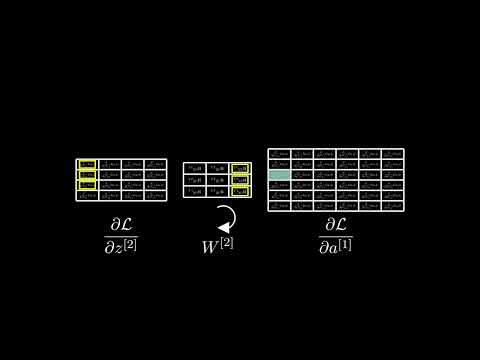

In [ ]:
#| echo: false
video_id = 'RllkdgU7R_A'
YouTubeVideo(video_id, allow_autoplay=True, loop=1, mute=1, playlist=video_id)

So we can conclude that

$$
\frac{\partial \mathcal{L}}{\partial a^{[1]}} = \frac{\partial \mathcal{L}}{\partial z^{[2]}} *_{full} rotate180(W^{[2]})
$$

>I wasn't able to find an official mathematical notation for "full convolution" so I just made up $*_{full}$

We can also check it in code:

In [ ]:
# Test that the full convolution of dz2 with the 180°-rotated W2 is equal to the da1 we calculated.
test_eq(
    convolve(
        dz2, np.rot90(W2, k=2, axes=(1, 0)), zero_pad_width=W2.shape[0] - 1, stride=1
    ),
    da1,
)

### Deriving $\frac{\partial \mathcal{L}}{\partial b^{[2]}}$

Now let's tackle $\frac{\partial \mathcal{L}}{\partial b^{[2]}}$: the gradient of the loss with respect to the bias term, $b^{[2]}$. In our calculation of $z^{[2]}$:

$$
z^{[2]} = a^{[1]} * W^{[2]} + b^{[2]}
$$

$b^{[2]}$ is a scalar that we add to each element of the matrix, $a^{[1]} * W^{[2]}$. For the purpose of this derivation, it's helpful to think of $b^{[2]}$ as a matrix with the same dimensions as $a^{[1]} * W^{[2]}$ in which the value of every element is the scalar value of $b^{[2]}$:

$$
\begin{bmatrix}
b^{[2]} & b^{[2]} & b^{[2]} & b^{[2]}\\
b^{[2]} & b^{[2]} & b^{[2]} & b^{[2]}\\
b^{[2]} & b^{[2]} & b^{[2]} & b^{[2]}\\
b^{[2]} & b^{[2]} & b^{[2]} & b^{[2]}\\
\end{bmatrix}
$$

To distinguish the scalar $b^{[2]}$ clearly from the matrix version, we'll call the matrix version $\mathbf{B^{[2]}}$:

$$
\mathbf{B^{[2]}} = 
\def\arraystretch{1.5}
\begin{bmatrix}
\mathbf{B^{[2]}_{11}} & \mathbf{B^{[2]}_{12}} & \mathbf{B^{[2]}_{13}} & \mathbf{B^{[2]}_{14}}\\
\mathbf{B^{[2]}_{21}} & \mathbf{B^{[2]}_{22}} & \mathbf{B^{[2]}_{23}} & \mathbf{B^{[2]}_{24}}\\
\mathbf{B^{[2]}_{31}} & \mathbf{B^{[2]}_{32}} & \mathbf{B^{[2]}_{33}} & \mathbf{B^{[2]}_{34}}\\
\mathbf{B^{[2]}_{41}} & \mathbf{B^{[2]}_{42}} & \mathbf{B^{[2]}_{43}} & \mathbf{B^{[2]}_{44}}\\
\end{bmatrix}
=
\begin{bmatrix}
b^{[2]} & b^{[2]} & b^{[2]} & b^{[2]}\\
b^{[2]} & b^{[2]} & b^{[2]} & b^{[2]}\\
b^{[2]} & b^{[2]} & b^{[2]} & b^{[2]}\\
b^{[2]} & b^{[2]} & b^{[2]} & b^{[2]}\\
\end{bmatrix}
$$

and plug it into the formula for $z^{[2]}$:

$$
z^{[2]} = a^{[1]} * W^{[2]} + \mathbf{B^{[2]}}
$$
Now the plus sign in the formular above is just plain matrix (element-wise) addition.

>Note: The transformation from $b^{[2]}$ to $\mathbf{B^{[2]}}$ I've written out here actually happens implicitly in the code we wrote earlier (`z2 = convolve(a1, W2, 0, 1) + b2`) because of [NumPy broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html).

We can then calculate the derivative of $\mathcal{L}$ with respect to this $\mathbf{B^{[2]}}$ matrix. Remember, we've got $\frac{\partial \mathcal{L}}{\partial z^{[2]}}$ and now we want $\frac{\partial \mathcal{L}}{\partial \mathbf{B^{[2]}}}$. 

Like we did in the calculation of $\frac{\partial \mathcal{L}}{\partial \mathbf{W^{[2]}}}$, we can apply the chain rule, element-wise. E.g. $\frac{\partial \mathcal{L}}{\partial \mathbf{B^{[2]_{11}}}}$ would be:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{B^{[2]}_{11}}} = \frac{\partial \mathcal{L}}{\partial z^{[2]}_{11}}\frac{\partial z^{[2]}_{11}}{\partial \mathbf{B^{[2]}_{11}}} + \frac{\partial \mathcal{L}}{\partial z^{[2]}_{12}}\frac{\partial z^{[2]}_{12}}{\partial \mathbf{B^{[2]}_{11}}} + \cdots + \frac{\partial \mathcal{L}}{\partial z^{[2]}_{44}}\frac{\partial z^{[2]}_{44}}{\partial \mathbf{B^{[2]}_{11}}} 
$$

Of course, many of these terms are zero because $\frac{\partial z^{[2]}_{k, l}}{\partial \mathbf{B^{[2]}_{i, j}}} = 0$ when $k \neq i$ or $l \neq j$. But rather than trying to reason about this ourselves or simplify by hand to work out what this is really saying, we can instead just use `matrix_matrix_chain_rule()` to do it for us: 


In [ ]:
# Redo the calculation of z2 using the B2 matrix
a1 = ndarray_of_indexed_base(IndexedBase(r'a^{[1]}'), (6, 6))
W2 = ndarray_of_indexed_base(IndexedBase(r'W^{[2]}'), (3, 3))
conv_result = convolve(a1, W2, 0, 1)
B2 = ndarray_of_indexed_base(IndexedBase(r'B^{[2]}'), conv_result.shape)
z2 = conv_result + B2

# Compute dB2
dB2 = matrix_matrix_chain_rule(dz2, z2, B2)

Markdown(matrix_to_markdown(dB2))

$$\begin{bmatrix}
\frac{\partial}{\partial {z^{[2]}}_{1,1}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{1,2}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{1,3}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{1,4}} \mathcal{L}{\left(y,\hat{y} \right)}\\
\frac{\partial}{\partial {z^{[2]}}_{2,1}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{2,2}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{2,3}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{2,4}} \mathcal{L}{\left(y,\hat{y} \right)}\\
\frac{\partial}{\partial {z^{[2]}}_{3,1}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{3,2}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{3,3}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{3,4}} \mathcal{L}{\left(y,\hat{y} \right)}\\
\frac{\partial}{\partial {z^{[2]}}_{4,1}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{4,2}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{4,3}} \mathcal{L}{\left(y,\hat{y} \right)} & \frac{\partial}{\partial {z^{[2]}}_{4,4}} \mathcal{L}{\left(y,\hat{y} \right)}\end{bmatrix}
$$

Each element of this is the same as the corresponding element of $\frac{\partial \mathcal{L}}{\partial z^{[2]}}$. We can confirm that 

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{B^{[2]}}} = \frac{\partial \mathcal{L}}{\partial z^{[2]}}
$$

in code: 

In [ ]:
test_eq(dB2, dz2)